In [375]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression

In [376]:
# Constants
num_samples = 500
r = 1

# Noise
# noise_mean = 0     
# noise_std_dev = 0.1
# noise = np.random.normal(noise_mean, noise_std_dev, num_samples)
noise = np.random.uniform(-.1,.1, num_samples)


# # Uniform over x
# sign = np.random.choice([-1,1],num_samples)
# x = np.random.uniform(-1,1, num_samples)
# y = sign * np.sqrt(1 - x**2) + noise


# Generate x and y with theta
theta = np.random.uniform(0, 2 * np.pi, num_samples)
x = np.cos(theta) * (r + noise)
y = np.sin(theta) * (r + noise)

In [377]:
# Convert to PyTorch tensors
X_train = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)  # Input: x (Shape: [num_samples, 1])
Y_train = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)  # Output: y (Shape: [num_samples, 1])

In [378]:
class NNLeastSquaresWithStd(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNLeastSquaresWithStd, self).__init__()
        
        # Shared hidden layers
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Output layers for mean and standard deviation
        self.mu = nn.Linear(hidden_dim, 1)  # Predicts the mean
        self.sigma = nn.Linear(hidden_dim, 1)  # Predicts raw std dev (needs activation)

    def forward(self, x):
        h = self.hidden(x)  # Shared hidden layers
        mu = self.mu(h)  # Predict the mean
        
        # Ensure sigma is positive using Softplus (or ReLU if preferred)
        sigma = torch.nn.functional.softplus(self.sigma(h)) + 1e-6  # Keeps sigma > 0
        
        return mu, sigma


In [379]:
def nll_loss(mu, sigma, y):
    """
    Negative Log-Likelihood Loss for learning both mean and uncertainty.
    """
    loss = 0.5 * ((y - mu) ** 2 / (sigma ** 2)) + torch.log(sigma)
    return loss.mean()


In [380]:
# Initialize the model
input_dim = 1  # Only x is given as input
output_dim = 1  # Predicts y

#consistently bad results with 1, sometimes bad reults with 2,4,16,32
hidden_dim = 128
model = NNLeastSquaresWithStd(input_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [381]:
# Training Loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    mu, sigma = model(X_train)
    loss = nll_loss(mu, sigma, Y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [0/1000], Loss: 0.1522
Epoch [100/1000], Loss: -0.0877
Epoch [200/1000], Loss: -0.0879
Epoch [300/1000], Loss: -0.0903
Epoch [400/1000], Loss: -0.0934
Epoch [500/1000], Loss: -0.0950
Epoch [600/1000], Loss: -0.0972
Epoch [700/1000], Loss: -0.0969
Epoch [800/1000], Loss: -0.0973
Epoch [900/1000], Loss: -0.1019


<function matplotlib.pyplot.show(close=None, block=None)>

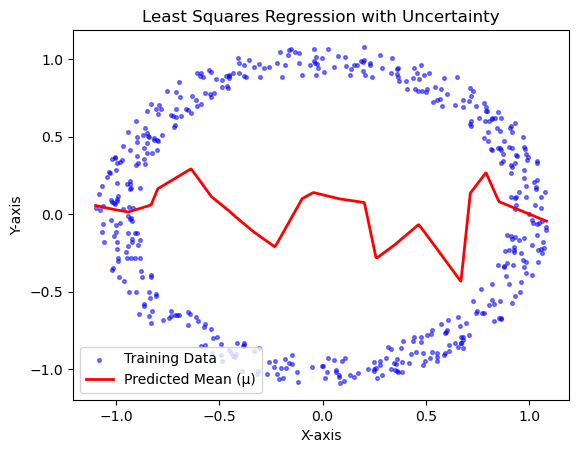

In [382]:
import matplotlib.pyplot as plt
import torch

# Switch model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    mu_pred, sigma_pred = model(X_train)  # Predict mean and std

# Convert tensors to numpy arrays
X_train_np = X_train.cpu().numpy()
Y_train_np = Y_train.cpu().numpy()
mu_np = mu_pred.cpu().numpy().flatten()
sigma_np = sigma_pred.cpu().numpy().flatten()

# Sort the data for a smooth line plot
sorted_indices = np.argsort(X_train_np.flatten())
X_sorted = X_train_np.flatten()[sorted_indices]
mu_sorted = mu_np[sorted_indices]
sigma_sorted = sigma_np[sorted_indices]

# Plot the training data points
plt.scatter(X_train_np, Y_train_np, color='blue', alpha=0.5, s=7, label='Training Data')

# Plot the predicted mean (μ)
plt.plot(X_sorted, mu_sorted, color='red', linewidth=2, label='Predicted Mean (μ)')

# Plot uncertainty bands (±σ)
# plt.fill_between(X_sorted, mu_sorted - sigma_sorted, mu_sorted + sigma_sorted, color='red', alpha=0.2, label='Uncertainty (μ ± σ)')

# Labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Least Squares Regression with Uncertainty')
plt.legend()

# Show the plot
plt.show


In [383]:
sigma_global = torch.sqrt(torch.mean((mu - Y_train) ** 2))


In [384]:
print(sigma_global)

tensor(0.6793, grad_fn=<SqrtBackward0>)
